=== Current Car Details ===


Enter current car market value (in USD, e.g., 10000):  11000
Operating Cost for Year 1 (in USD):  1100
Operating Cost for Year 2 (in USD):  1200
Operating Cost for Year 3 (in USD):  1450
Current Car Fuel Economy (km/l) (e.g., 15):  12.7
Style Score for Current Car (0-10, e.g., 5):  6



=== Current Car Nationality ===


Select nationality (Japanese/Korean/American/German):  American



=== New Car Selection ===
Available Challenger Cars: ['Ford Explorer', 'Toyota Camry', 'Nissan Altima', 'Honda Accord', 'BMW 5 Series', 'Hyundai Sonata']


Select the new car you want to buy (e.g., Toyota Camry):  Honda Accord
Style Score for Honda Accord (0-10, e.g., 5):  9



=== Decision Factor Weights (0-10) ===


Weight for Style (0-10):  4
Weight for Reliability (0-10):  1
Weight for Cost (0-10):  4
Weight for Fuel Economy (0-10):  1
Weight for Safety (0-10):  0



=== Results ===
Scores:
- Cost Score: Current Car = 0.6591, New Car = 0.3409
- Reliability Score: Current Car = 0.8000, New Car = 0.9000
- Style Score: Current Car = 0.6000, New Car = 0.9000
- Safety Score: Current Car = 0.8500, New Car = 0.7000
- Fuel Economy Score: Current Car = 0.4233, New Car = 0.8300

Weighted Scores
- Current Car Weighted Score: 0.6260
- New Car Weighted Score: 0.6693

Justification
- Keeping your car will cost you $4544.42 over the next 5 years.
- Replacing your car will cost you $8788.04 over the next 5 years.
- The challenger has a higher weighted score, indicating better value.

Recommendation: Replace the current car with the new one.


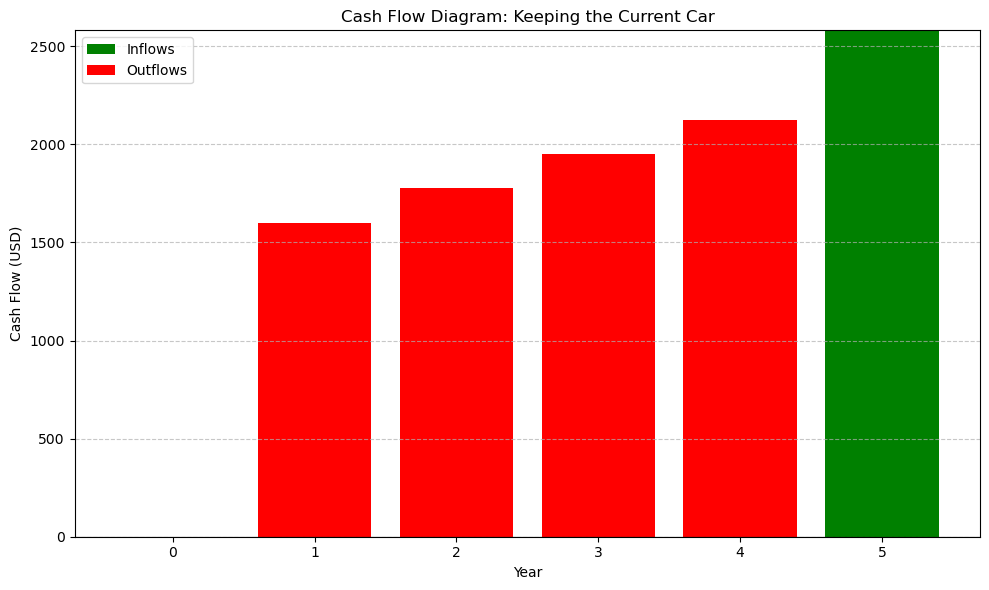

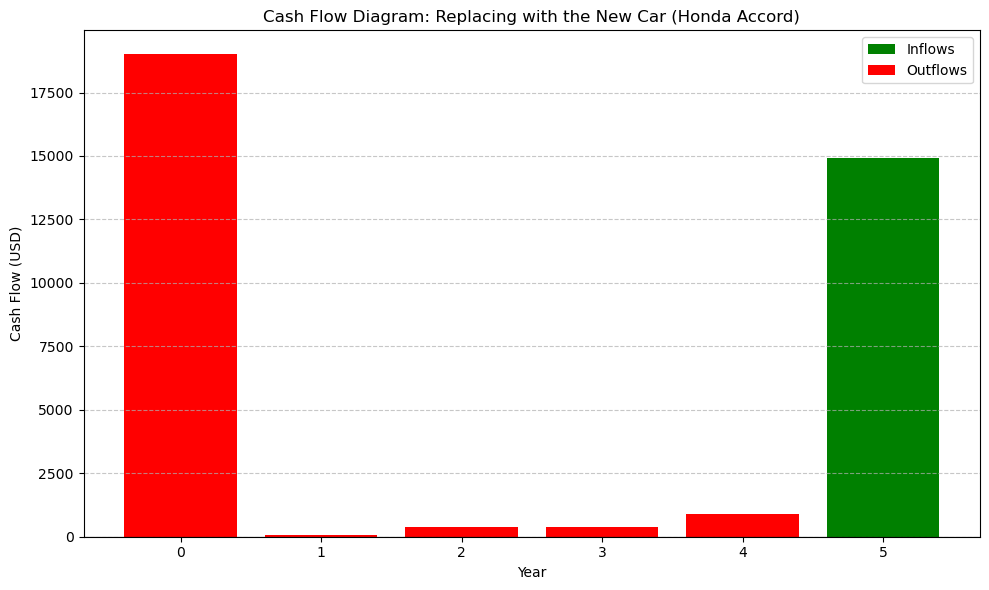

In [1]:
# === Car Replacement Decision Support System ===

# 1. Imports and Function Definitions
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_weighted_score(cost_score, style_score, reliability_score, fuel_economy_score, safety_score, weights):
    """
    Compute the final weighted score based on user-defined weights.
    """
    return (weights['cost'] * cost_score +
            weights['style'] * style_score +
            weights['reliability'] * reliability_score +
            weights['fuel_economy'] * fuel_economy_score +
            weights['safety'] * safety_score)

def calculate_pv(cash_flows, discount_rate=0.05):
    """
    Calculate the Present Value (PV) of a series of cash flows.
    Year 0 is not discounted.
    """
    return sum([cf / (1 + discount_rate)**year for year, cf in enumerate(cash_flows, start=0)])

def predict_operating_costs(operating_costs):
    """
    Predict the operating costs for the next 5 years using linear regression.
    """
    past_years = np.array([1, 2, 3]).reshape(-1, 1)  # Past 3 years
    model = LinearRegression()
    model.fit(past_years, operating_costs)
    future_years = np.array([4, 5, 6, 7, 8]).reshape(-1, 1)  # Next 5 years
    predicted = model.predict(future_years)
    predicted = [max(0, cf) for cf in predicted]  # Ensure no negative costs
    return predicted  # Already a list

def load_excel_data(file_path, sheet_name, required_columns):
    """
    Load data from an Excel file and validate required columns.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Error: Missing columns {missing_cols} in sheet '{sheet_name}' of '{file_path}'.")
        df['Car'] = df['Car'].str.strip()
        return df
    except ValueError as ve:
        raise ve
    except Exception as e:
        raise Exception(f"An error occurred while reading '{file_path}': {e}")

def format_cash_flows(cash_flows):
    """
    Separate cash flows into inflows and outflows for better visualization.
    Returns two lists: inflows and outflows.
    """
    inflows = [cf if cf > 0 else 0 for cf in cash_flows]
    outflows = [abs(cf) if cf < 0 else 0 for cf in cash_flows]
    return inflows, outflows

# 2. Load Data from Excel Files
# Define file paths (ensure paths are correct relative to your notebook)
operating_costs_file = '../data/challenger_operating_costs.xlsx'
fuel_economy_file = '../data/challenger_fuel_economy.xlsx'
buying_prices_file = '../data/challenger_buying_prices.xlsx'

# Load Operating Costs
try:
    df_operating_costs = load_excel_data(operating_costs_file, 'OperatingCosts', ['Car', 'Year1', 'Year2', 'Year3', 'Year4', 'Year5'])
    challenger_operating_costs_data = df_operating_costs.set_index('Car').T.to_dict('list')
except Exception as e:
    print(e)
    exit(1)

# Load Fuel Economy Data
try:
    df_fuel_economy = load_excel_data(fuel_economy_file, 'FuelEconomy', ['Car', 'FuelEconomy'])
    fuel_economy_data = pd.Series(df_fuel_economy.FuelEconomy.values, index=df_fuel_economy.Car).to_dict()
except Exception as e:
    print(e)
    exit(1)

# Load Buying Prices Data
try:
    df_buying_prices = load_excel_data(buying_prices_file, 'BuyingPrices', ['Car', 'BuyingPrice'])
    challenger_buying_prices = pd.Series(df_buying_prices.BuyingPrice.values, index=df_buying_prices.Car).to_dict()
except Exception as e:
    print(e)
    exit(1)

# 3. Collect User Inputs
# Predefined reliability and safety scores
reliability_scores = {'Japanese': 0.9, 'Korean': 0.8, 'American': 0.8, 'German': 0.7}
safety_scores = {'Japanese': 0.7, 'Korean': 0.8, 'American': 0.85, 'German': 0.9}

# Map challenger car models to nationalities
challenger_nationality = {
    'Ford Explorer': 'American',
    'Honda Accord': 'Japanese',
    'Nissan Altima': 'Japanese',
    'Toyota Camry': 'Japanese',
    'Hyundai Sonata': 'Korean',
    'BMW 5 Series': 'German'
}

# Define depreciation rates based on nationality
depreciation_rates = {
    'American': 0.15,
    'Japanese': 0.11,
    'German': 0.18,
    'Korean': 0.13
}

print("=== Current Car Details ===")
# Market Value
defender_market_value = input("Enter current car market value (in USD, e.g., 10000): ")
try:
    defender_market_value = float(defender_market_value)
    if defender_market_value < 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number for market value.")
    exit(1)

# Operating Costs for 3 Years
defender_operating_costs = []
for i in range(1, 4):
    cost = input(f"Operating Cost for Year {i} (in USD): ")
    try:
        cost = float(cost)
        if cost < 0:
            raise ValueError
        defender_operating_costs.append(cost)
    except ValueError:
        print("Invalid input. Please enter a positive number for operating costs.")
        exit(1)

# Fuel Economy
defender_fuel_economy_kmpl = input("Current Car Fuel Economy (km/l) (e.g., 15): ")
try:
    defender_fuel_economy_kmpl = float(defender_fuel_economy_kmpl)
    if defender_fuel_economy_kmpl <= 0:
        raise ValueError
    defender_fuel_economy_score = defender_fuel_economy_kmpl / 30
except ValueError:
    print("Invalid input. Please enter a positive number for fuel economy.")
    exit(1)

# Style Score
style_score_defender_input = input("Style Score for Current Car (0-10, e.g., 5): ")
try:
    style_score_defender_input = float(style_score_defender_input)
    if not 0 <= style_score_defender_input <= 10:
        raise ValueError
    style_score_defender = style_score_defender_input / 10
except ValueError:
    print("Invalid input. Please enter a number between 0 and 10 for style score.")
    exit(1)

# Car Nationality
print("\n=== Current Car Nationality ===")
origin_defender = input("Select nationality (Japanese/Korean/American/German): ").strip()
if origin_defender not in reliability_scores:
    print("Invalid nationality selection.")
    exit(1)

# New Car Selection
print("\n=== New Car Selection ===")
print("Available Challenger Cars:", list(challenger_buying_prices.keys()))
challenger_car = input("Select the new car you want to buy (e.g., Toyota Camry): ").strip()
if challenger_car not in challenger_buying_prices:
    print("Invalid car selection.")
    exit(1)

# Retrieve Challenger Operating Costs
challenger_operating_costs = challenger_operating_costs_data.get(challenger_car)
if not challenger_operating_costs:
    print(f"Operating costs for {challenger_car} not found.")
    exit(1)

# Retrieve Challenger Buying Price
challenger_buying_price = challenger_buying_prices.get(challenger_car)
if challenger_buying_price is None:
    print(f"Buying price for {challenger_car} not found.")
    exit(1)

# Retrieve Challenger Fuel Economy
challenger_fuel_economy_kmpl = fuel_economy_data.get(challenger_car)
if challenger_fuel_economy_kmpl is None:
    print(f"Fuel economy data for {challenger_car} not found.")
    exit(1)
challenger_fuel_economy_score = challenger_fuel_economy_kmpl / 30

# Style Score for Challenger
style_score_challenger_input = input(f"Style Score for {challenger_car} (0-10, e.g., 5): ")
try:
    style_score_challenger_input = float(style_score_challenger_input)
    if not 0 <= style_score_challenger_input <= 10:
        raise ValueError
    style_score_challenger = style_score_challenger_input / 10
except ValueError:
    print("Invalid input. Please enter a number between 0 and 10 for style score.")
    exit(1)

# Collect Decision Factor Weights
print("\n=== Decision Factor Weights (0-10) ===")
weights = {}
factors = ['Style', 'Reliability', 'Cost', 'Fuel Economy', 'Safety']
for factor in factors:
    weight = input(f"Weight for {factor} (0-10): ")
    try:
        weight = float(weight)
        if not 0 <= weight <= 10:
            raise ValueError
        weights[factor.lower().replace(" ", "_")] = weight / 10
    except ValueError:
        print(f"Invalid input. Please enter a number between 0 and 10 for {factor} weight.")
        exit(1)

# Ensure at least one weight is non-zero
if all(v == 0 for v in weights.values()):
    print("At least one weight must be greater than zero.")
    exit(1)

# 4. Perform Calculations

# Predict Operating Costs for Defender over next 5 years
predicted_defender_costs = predict_operating_costs(defender_operating_costs)

# Determine Depreciation Rates
dep_rate_defender = depreciation_rates.get(origin_defender, 0.1)  # Default 10% if not found
origin_challenger = challenger_nationality.get(challenger_car, 'Japanese')  # Default Japanese
dep_rate_challenger = depreciation_rates.get(origin_challenger, 0.1)  # Default 10% if not found

# Calculate Residual Values at Year 5 using Compound Depreciation
residual_value_defender = defender_market_value * (1 - dep_rate_defender) ** 5
residual_value_challenger = challenger_buying_price * (1 - dep_rate_challenger) ** 5

# Scenario 1: Keeping the Defender Car
# Year 0: No cash flow
# Years 1-4: Operating costs (cash outflows)
# Year 5: Operating cost (cash outflow) + residual value (cash inflow)
cash_flow_defender = [0]  # Year 0
cash_flow_defender += [-cost for cost in predicted_defender_costs[:4]]  # Years 1-4
cash_flow_defender.append(-predicted_defender_costs[4] + residual_value_defender)  # Year 5

# Scenario 2: Replacing with the Challenger
# Year 0: Defender market value (cash inflow) - Buying price of challenger (cash outflow)
# Years 1-4: Operating costs for challenger (cash outflows)
# Year 5: Operating cost (cash outflow) + residual value (cash inflow)
initial_cash_flow_challenger = defender_market_value - challenger_buying_price
cash_flow_challenger = [initial_cash_flow_challenger]  # Year 0
cash_flow_challenger += [-cost for cost in challenger_operating_costs[:4]]  # Years 1-4
cash_flow_challenger.append(-challenger_operating_costs[4] + residual_value_challenger)  # Year 5

# Verify that both cash flows have 6 elements (Year 0 to Year 5)
if len(cash_flow_defender) != 6 or len(cash_flow_challenger) != 6:
    print("Error: Cash flow lists do not have 6 elements corresponding to years 0-5.")
    exit(1)

# Calculate Present Values
defender_pv = calculate_pv(cash_flow_defender)
challenger_pv = calculate_pv(cash_flow_challenger)

# Calculate Cost Scores (Higher score is better)
total_pv = defender_pv + challenger_pv
if total_pv == 0:
    print("Error: Total present value of costs is zero, cannot compute cost scores.")
    exit(1)

cost_score_defender = challenger_pv / total_pv
cost_score_challenger = defender_pv / total_pv

# Retrieve Reliability and Safety Scores
reliability_score_defender = reliability_scores.get(origin_defender, 0.8)
safety_score_defender = safety_scores.get(origin_defender, 0.8)

reliability_score_challenger = reliability_scores.get(origin_challenger, 0.8)
safety_score_challenger = safety_scores.get(origin_challenger, 0.8)

# Calculate Weighted Scores
defender_weighted_score = calculate_weighted_score(
    cost_score_defender, style_score_defender, reliability_score_defender,
    defender_fuel_economy_score, safety_score_defender, weights
)
challenger_weighted_score = calculate_weighted_score(
    cost_score_challenger, style_score_challenger, reliability_score_challenger,
    challenger_fuel_economy_score, safety_score_challenger, weights
)

# 5. Display Results, Recommendation, and Cash Flow Diagrams

# Display Scores
print("\n=== Results ===")
print("Scores:")
print(f"- Cost Score: Current Car = {cost_score_defender:.4f}, New Car = {cost_score_challenger:.4f}")
print(f"- Reliability Score: Current Car = {reliability_score_defender:.4f}, New Car = {reliability_score_challenger:.4f}")
print(f"- Style Score: Current Car = {style_score_defender:.4f}, New Car = {style_score_challenger:.4f}")
print(f"- Safety Score: Current Car = {safety_score_defender:.4f}, New Car = {safety_score_challenger:.4f}")
print(f"- Fuel Economy Score: Current Car = {defender_fuel_economy_score:.4f}, New Car = {challenger_fuel_economy_score:.4f}")

# Display Weighted Scores
print("\nWeighted Scores")
print(f"- Current Car Weighted Score: {defender_weighted_score:.4f}")
print(f"- New Car Weighted Score: {challenger_weighted_score:.4f}")

# Display Justification
print("\nJustification")
print(f"- Keeping your car will cost you ${abs(defender_pv):.2f} over the next 5 years.")
print(f"- Replacing your car will cost you ${abs(challenger_pv):.2f} over the next 5 years.")
print(f"- The challenger has a {'higher' if challenger_weighted_score > defender_weighted_score else 'lower'} weighted score, indicating {'better' if challenger_weighted_score > defender_weighted_score else 'worse'} value.")

# Provide Recommendation
if challenger_weighted_score > defender_weighted_score:
    recommendation = "Replace the current car with the new one."
else:
    recommendation = "Keep your car."
print(f"\nRecommendation: {recommendation}")

# Cash Flow Diagrams

# Define years
years = np.arange(0, 6)  # Years 0 to 5

# Format cash flows for defender
inflows_defender, outflows_defender = format_cash_flows(cash_flow_defender)

# Format cash flows for challenger
inflows_challenger, outflows_challenger = format_cash_flows(cash_flow_challenger)

# Plot Cash Flow Diagram for Scenario 1: Keeping the Defender
plt.figure(figsize=(10, 6))
plt.bar(years, inflows_defender, color='green', label='Inflows')
plt.bar(years, outflows_defender, bottom=inflows_defender, color='red', label='Outflows')
plt.xlabel('Year')
plt.ylabel('Cash Flow (USD)')
plt.title('Cash Flow Diagram: Keeping the Current Car')
plt.xticks(years)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Cash Flow Diagram for Scenario 2: Replacing with the Challenger
plt.figure(figsize=(10, 6))
plt.bar(years, inflows_challenger, color='green', label='Inflows')
plt.bar(years, outflows_challenger, bottom=inflows_challenger, color='red', label='Outflows')
plt.xlabel('Year')
plt.ylabel('Cash Flow (USD)')
plt.title(f'Cash Flow Diagram: Replacing with the New Car ({challenger_car})')
plt.xticks(years)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
